<a href="https://colab.research.google.com/github/zuobinxiong/CS789/blob/main/Lab5_FL_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [ ]:
# Hyperparameters
#
num_clients = 10
num_selected = 5
Round = 10
iter_per_client = 1
batch_size = 32

pre_delta=1e-5
momentum=0.5
pre_lr=0.001


In [ ]:
# Creating decentralized datasets, IID data split
# download dataset
traindata = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
                       )

# split dataset
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
# train_loaders
train_loader_ls = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
        ), batch_size=batch_size, shuffle=True)

In [ ]:
# define local training algorithm
def client_update(client_model, optimizer, train_loader, epoch=5, client_id=0):
    client_model.train()
    criterion = nn.CrossEntropyLoss()

    for e in range(epoch):
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            # move data to cuda device
            data = ...
            # move labels to cuda device
            target = ...

            optimizer.zero_grad()
            output = client_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    print(f"client_: {client_id}\t"
          f"Train Epoch: {e+1} \t"
          f"Loss: {sum(losses)/len(losses):.4f}"
          )

    return loss.item()

In [ ]:
# define test model algorithm
def test(global_model, test_loader):
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # move data and label to cuda device
            data, target = ...
            # get model output
            output = ...
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    # calculate loss and accuracy
    test_loss = ...
    acc = ...

    return test_loss, acc

In [ ]:
# FedAvg algorithm aggregation
def server_aggregate(global_model, client_models, client_idx):
    # get the model dict from global model
    global_dict = ...
    for k in global_dict.keys():
        # calculate the average parameters of all models
        global_dict[k] = ...
    # load average model parameters into global model
    global_model....
    for model in client_models:
        # distributed global model to all client models
        model....
    return global_model, client_models

In [ ]:
# initialize models and optimizers
client_models, optimizers = [], []

for client in range(num_clients):
    model=Net().to("cuda")
    # add model into list
    ...

    # define a optimizer of model
    optimizer = optim.RMSprop(model.parameters(), lr=pre_lr)
    # add optimzier into list
    ...


In [ ]:
# Instantiate global model
global_model = ...

# Runnining FedAvg FL
test_acc, test_losses = [], []

for r in range(Round):
    # select random clients
    client_idx = ...
    print('selected clients', client_idx)

    # client update
    loss = 0
    for i in range(num_selected):
        # train each local model of selected
        loss= ...

        loss+=loss

    # serer aggregate all models
    ...
    # est model accuracy and loss
    test_loss, acc = ...

    test_acc.append(acc)
    test_losses.append(test_loss)
    print('%d-th round' % (r+1))
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f |' % (loss / num_selected, test_loss, acc))

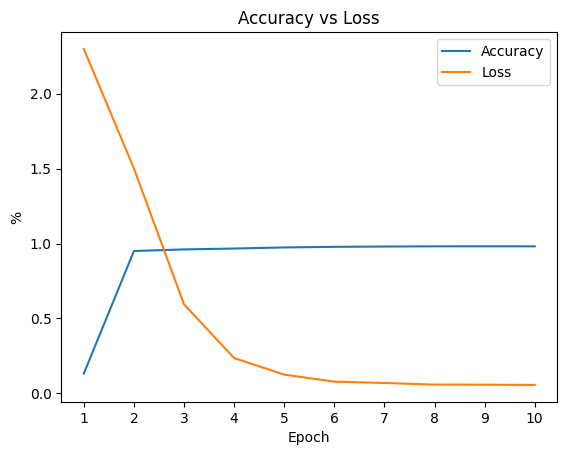

In [ ]:
from pylab import plt
x = [i+1 for i in range(Round)]
plt.plot(x,test_acc,label='Accuracy')
plt.plot(x,test_losses,label='Loss')
plt.title("Accuracy vs Loss")
plt.xlabel('Epoch')
plt.ylabel('%')
plt.xticks(x)
plt.legend()
plt.show()
# plt.savefig()

In [ ]:
# NON-IID case: every client has images of two categories chosen from [0, 1, 2, 3, 4], [5,6,7,8,9].

# Creating decentralized datasets
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
# collect all data with labels in [0:5]
target_labels_split += ...

# collect all data with labels in [5:10]
target_labels_split += ...
# create split datasets list
traindata_split = ...
# create data loader
train_loaders = ...


In [ ]:
# NON-IID case: every client has images of two categories chosen from [0, 1], [2, 3], [4, 5], [6, 7], or [8, 9].

# Creating decentralized datasets
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * i +2 )].sum(0))[0], int(60000 / num_clients))[0:2]

traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split]

train_loaders = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True, drop_last=True) for x in traindata_split]


In [ ]:
# NON-IID case: every client has images of two categories chosen from [0, 1, 2, 3], [1, 2, 3, 4].....[9,0,1,2]

# Creating decentralized datasets
target_labels = torch.stack([traindata.targets == i for i in range(10)])
target_labels_split = []
for i in range(5):
    target_labels_split += torch.split(torch.where(target_labels[(2 * i):(2 * i +2 )].sum(dim=0))[0], 10000)[0:2]

target_labels_split_4_class = []
for i in range (10):
    target_labels_split_4_class.append(torch.concat((target_labels_split[i%10],target_labels_split[(i+1)%10],target_labels_split[(i+1)%10],target_labels_split[(i+1)%10])))

traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in target_labels_split_4_class]

train_loaders = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True, drop_last=True) for x in traindata_split]


In [ ]:
# initialize models and optimizers
client_models_n, optimizers_n = [], []

for client in range(num_clients):
    model=Net().to("cuda")
    # initialize optimizer
    optimizer = optim.RMSprop(model.parameters(), lr=pre_lr)
    # add model into list
    client_models_n....
    # add optimizer into list
    optimizers_n....

In [ ]:
# Instantiate global model

global_model_n = client_models_n[0]

# Runnining FedAvg FL
test_acc, test_losses = [], []

for r in range(Round):
    # select random clients
    client_idx = ...
    print('selected clients', client_idx)
    # client update
    loss = 0
    for i in range(num_selected):
        # train local model
        loss= ...
        loss+=loss

    # serer aggregate
    global_model_n, client_models_n = ...
    test_loss, acc = test(global_model_n, test_loader)

    test_acc.append(acc)
    test_losses.append(test_loss)
    print('%d-th round' % (r+1))
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f |' % (loss / num_selected, test_loss, acc))

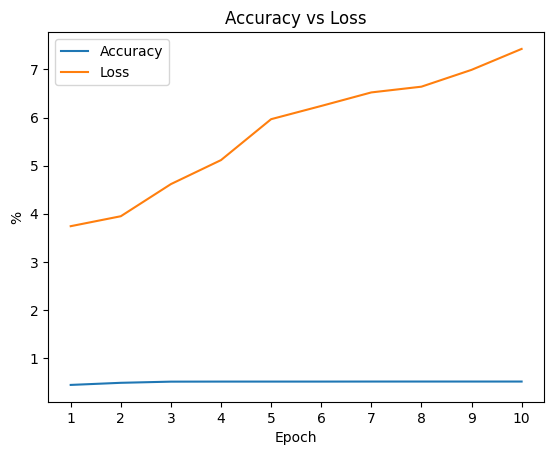

In [ ]:
from pylab import plt
x = [i+1 for i in range(Round)]
plt.plot(x,test_acc,label='Accuracy')
plt.plot(x,test_losses,label='Loss')
plt.title("Accuracy vs Loss")
plt.xlabel('Epoch')
plt.ylabel('%')
plt.xticks(x)
plt.legend()
plt.show()
# plt.savefig()